*This notebook is an example of cell detection and image registration at BIL using Open OnDemand*

### Let's begin.
We'll need to install a Python package called `cellfinder`<br>
Full documentation can be found here:
https://docs.brainglobe.info/cellfinder/cellfinder-introduction<br>
Source code: https://github.com/brainglobe/cellfinder

In [ ]:
!pip install --user cellfinder

#### Let's create the required directories and copy atlas images for registration

In [1]:
!if [ ! -d ~/workshop ]; then mkdir ~/workshop; fi
!if [ ! -d ~/.brainglobe ]; then mkdir ~/.brainglobe; fi
!if [ ! -d ~/.brainglobe/allen_mouse_100um_v1.2 ]; then ln -s /bil/workshops/2022/data_submission/july/2023/allen_mouse_100um_v1.2 ~/.brainglobe/allen_mouse_100um_v1.2; fi

In [2]:
import warnings
warnings.filterwarnings('ignore')  # Disable warnings

#### Let's import all required modules

In [3]:
from cellfinder_core.main import main as cellfinder_run
from cellfinder_core.detect import detect
from cellfinder_core.tools.IO import read_with_dask
from imlib.IO.cells import save_cells
from brainreg.main import main as register

import os
import numpy as np
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
from skimage import exposure


# helper function for plots

def stretch_contrast(img):
    img_dtype = img.dtype
    dtype_max = np.iinfo(img_dtype).max
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    img = (img * dtype_max).astype(img_dtype)
    return img

# Cell detection

#### Let's set up our cell detection parameters
Homework: play with them, see how it affects the result

In [4]:
data_location = "/bil/workshops/2022/data_submission/july/2023/stpt_whole_brain.tif"

In [5]:
voxel_sizes = [50, 10, 10]
start_plane=0
end_plane=-1
n_free_cpus=2
soma_diameter=20
ball_xy_size=6
ball_z_size=50
ball_overlap_fraction=0.6
log_sigma_size=0.2
n_sds_above_mean_thresh=4
soma_spread_factor=1.4
max_cluster_size=100000

#### Let's read our image

In [6]:
signal_array = tifffile.imread(data_location)

#### Let's detect cells!

In [ ]:
detected_cells = detect.main(
    signal_array,
    start_plane,
    end_plane,
    voxel_sizes,
    soma_diameter,
    max_cluster_size,
    ball_xy_size,
    ball_z_size,
    ball_overlap_fraction,
    soma_spread_factor,
    n_free_cpus,
    log_sigma_size,
    n_sds_above_mean_thresh,
)

In [ ]:
# example use as a command-line tool
# !cellfinder --help
# !cellfinder -s {signal_channel_folder_with_tiffs} -b {background_channel_folder_with_tiffs} -o ~/cellfinder_output -v {voxel_sizes[0]} {voxel_sizes[1]} {voxel_sizes[2]} --orientation {orientation} --no-analyse --no-figures --no-classification

#### Understanding the output. Using Python's introspection tools

In [9]:
print("Detected cells", type(detected_cells), "length", len(detected_cells))
cell = detected_cells[0]
print("Each element is", type(cell))

Detected cells <class 'list'> length 422653
Each element is <class 'imlib.cells.cells.Cell'>


#### Now we can extract cell coordinates and save them to csv

In [10]:
extract_coords = lambda x: [x.z, x.y, x.x]
coords = list(map(extract_coords, detected_cells))
coords_np = np.array(coords)
np.save('workshop/cells.npy', coords_np)

coords_np.shape

(422653, 3)

In [11]:
df = pd.DataFrame()
df["axis-0"] = coords_np[:,0].squeeze()
df["axis-1"] = coords_np[:,1].squeeze()
df["axis-2"] = coords_np[:,2].squeeze()
df.to_csv('workshop/cells.csv')

#### Let's visualize a slice of our image with overlaid cell detections

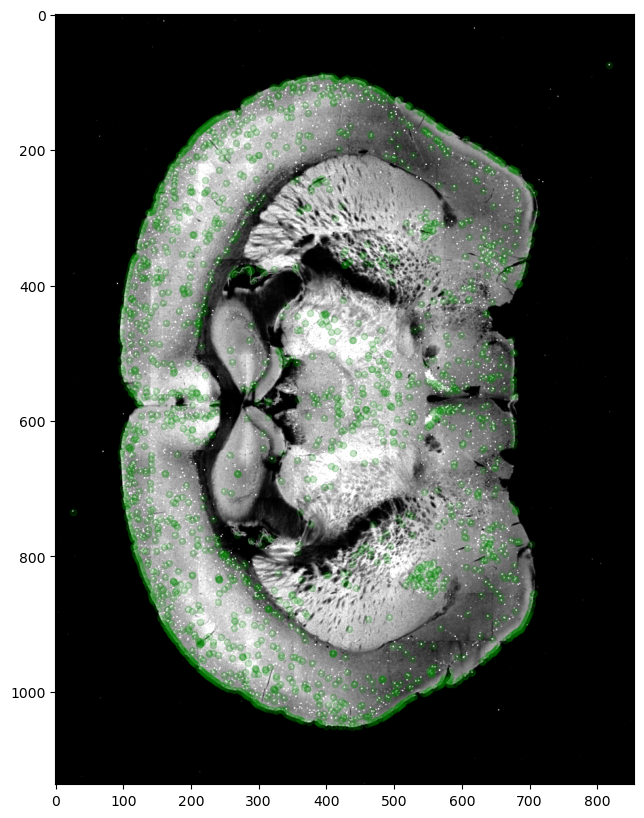

In [12]:
layer_to_show = 116
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(stretch_contrast(signal_array[layer_to_show,:,:]), cmap="gray")
points = coords_np[coords_np[:,0] == layer_to_show]
plt.scatter(x=points[:,2], y=points[:,1], c='g', s=20, alpha=0.2)

# Registration

#### Let's see what atlases are available
We'll use `bg_atlasapi` (brainglobe atlas API): https://docs.brainglobe.info/bg-atlasapi/introduction

In [13]:
from bg_atlasapi import show_atlases
show_atlases()

╭───────────────────────────────── Brainglobe Atlases ─────────────────────────────────╮
│                                                                           Latest     │
│  Name                              Downloaded  Updated  Local version    version     │
│  allen_mouse_25um                      ✔          ✔          1.2           1.2       │
│  allen_mouse_100um                     ✔          ✔          1.2           1.2       │
│  example_mouse_100um                                                       1.2       │
│  allen_mouse_10um                                                          1.2       │
│  allen_mouse_50um                                                          1.2       │
│  mpin_zfish_1um                                                            1.0       │
│  allen_human_500um                                                         0.1       │
│  kim_mouse_10um                                                            1.0       │
│  kim_mouse_25um                                                            1.0       │
│  kim_mouse_50um                                                            1.0       │
│  kim_mouse_100um                                                           1.0       │
│  osten_mouse_10um                                                          1.1       │
│  osten_mouse_25um                                                          1.1       │
│  osten_mouse_50um                                                          1.1       │
│  osten_mouse_100um                                                         1.1       │
│  allen_cord_20um                                                           1.0       │
│  azba_zfish_4um                                                            1.1       │
│  whs_sd_rat_39um                                                           1.0       │
│  perens_lsfm_mouse_20um                                                    1.0       │
│  admba_3d_e11_5_mouse_16um                                                 1.0       │
│  admba_3d_e13_5_mouse_16um                                                 1.0       │
│  admba_3d_e15_5_mouse_16um                                                 1.0       │
│  admba_3d_e18_5_mouse_16um                                                 1.0       │
│  admba_3d_p4_mouse_16.752um                                                1.0       │
│  admba_3d_p14_mouse_16.752um                                               1.0       │
│  admba_3d_p28_mouse_16.752um                                               1.0       │
│  admba_3d_p56_mouse_25um                                                   1.0       │
│  princeton_mouse_20um                                                      1.0       │
│  kim_dev_mouse_stp_10um                                                    1.1       │
│  kim_dev_mouse_idisco_10um                                                 1.1       │
│  kim_dev_mouse_mri_a0_10um                                                 1.1       │
│  kim_dev_mouse_mri_adc_10um                                                1.1       │
│  kim_dev_mouse_mri_dwi_10um                                                1.1       │
│  kim_dev_mouse_mri_fa_10um                                                 1.1       │
│  kim_dev_mouse_mri_mtr_10um                                                1.1       │
│  kim_dev_mouse_mri_t2_10um                                                 1.1       │
╰──────────────────────────────────────────────────────────────────────────────────────╯

#### We'll now explore what is in the atlas

In [14]:
from bg_atlasapi import BrainGlobeAtlas
atlas = BrainGlobeAtlas("allen_mouse_100um")

dir(atlas)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rich_console__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotation',
 '_get_from_structure',
 '_hemispheres',
 '_idx_from_coords',
 '_lookup',
 '_reference',
 '_remote_url_base',
 'additional_references',
 'annotation',
 'atlas_name',
 'brainglobe_dir',
 'check_latest_version',
 'download_extract_file',
 'get_structure_ancestors',
 'get_structure_descendants',
 'get_structure_mask',
 'hemisphere_from_coords',
 'hemispheres',
 'hierarchy',
 'interm_download_dir',
 'left_hemisphere_value',
 'local_full_name',
 'local_version',
 'lookup_df',
 'mesh_from_structure',
 'meshfile_from_structure',
 'metadata',
 'orientation',
 'reference',
 'remote_url',
 'remot

In [15]:
print("Atlas shape, px:", atlas.shape)
print("Atlas shape, microns:", atlas.shape_um)
print("Atlas resolution:", atlas.resolution)
print("Atlas orientation:", atlas.orientation)

Atlas shape, px: (132, 80, 114)
Atlas shape, microns: (13200.0, 8000.0, 11400.0)
Atlas resolution: (100.0, 100.0, 100.0)
Atlas orientation: asr


#### Let's plot the reference image

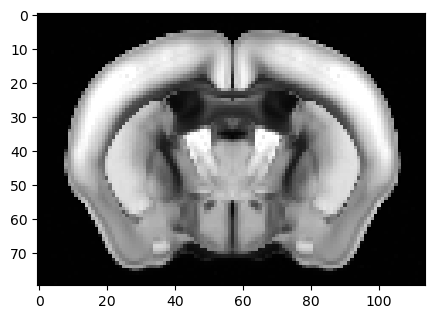

In [16]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(atlas.reference[60,:,:]), cmap="gray")

#### ... And the annotations of structures

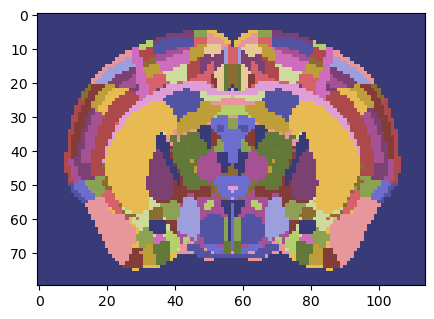

In [17]:
values, indices = np.unique(atlas.annotation, return_inverse=True)
indices = indices.reshape(atlas.annotation.shape)
plt.imshow(indices[60,:,:], cmap="tab20b")

#### We are ready to register our image (target) to the atlas (reference) using `brainreg`

#### Let's specify registration parameters
Description of all options is here: https://docs.brainglobe.info/brainreg/tutorial

In [18]:
orientation = "ars"  # anterior-right-superior
voxel_spacing = [50, 10, 10]  # microns
atlas = "allen_mouse_100um"  # atlas name from bg_atlasapi python package
output_folder = "workshop/registration"

In [19]:
from brainreg.paths import Paths
paths = Paths(output_folder)

from argparse import Namespace

niftyreg_args = Namespace()
niftyreg_args.affine_n_steps = 6
niftyreg_args.affine_use_n_steps = 5
niftyreg_args.freeform_n_steps = 6
niftyreg_args.freeform_use_n_steps = 4
niftyreg_args.bending_energy_weight = 0.95
niftyreg_args.grid_spacing = -10
niftyreg_args.smoothing_sigma_reference = -1.0
niftyreg_args.smoothing_sigma_floating = -1.0
niftyreg_args.histogram_n_bins_floating = 128
niftyreg_args.histogram_n_bins_reference = 128

#### ... and run the registration

In [20]:
register(
    atlas,
    orientation,
    data_location,
    paths,
    voxel_spacing,
    niftyreg_args,
)
print("Registration done!")

filtering: 100%|██████████| 114/114 [00:00<00:00, 528.79plane/s]


Registration done!


In [ ]:
# usage as a command line tool
# brainreg --help
# brainreg {background_channel} {output_folder} -v {voxel_spacing[0]} {voxel_spacing[1]} {voxel_spacing[2]} --orientation {orientation} --atlas {atlas}

#### What are the outputs? 

In [21]:
!ls {output_folder}  # shell command with python variable substitution

boundaries.tiff		  downsampled_standard.tiff
deformation_field_0.tiff  registered_atlas.tiff
deformation_field_1.tiff  registered_hemispheres.tiff
deformation_field_2.tiff  volumes.csv
downsampled.tiff


#### Let's plot them!

In [22]:
downsampled_img = tifffile.imread("workshop/registration/downsampled.tiff")
boundary_img = tifffile.imread("workshop/registration/registered_atlas.tiff")
downsampled_img.shape

(135, 86, 114)

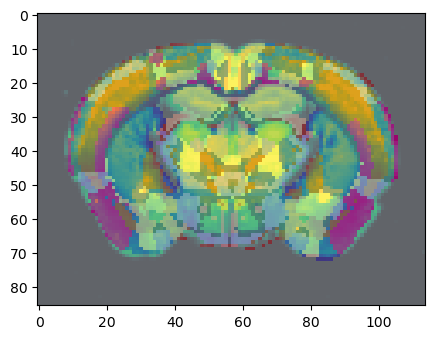

In [24]:
plot_layer = 60
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(downsampled_img[plot_layer,:,:]))
values, indices = np.unique(boundary_img, return_inverse=True)
indices = indices.reshape(boundary_img.shape)
plt.imshow(indices[plot_layer,:,:], cmap="Accent", alpha=0.5)